# Telegram Group Chat analysis

I've often felt I was the most talkative among my closest friends. Since I'm a scientist, I decided to put this to the test using a few Data Science techniques. The results I found were pretty Interesting

In [1]:
# taking care of dependencies I'll be using
import json
import pandas as pd
import unidecode
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import plotly.express as px
from datetime import datetime
import numpy as np
import matplotlib
import re
import seaborn as sns
from itertools import groupby
from collections import defaultdict

###### Telegram allows you to download your personal chat history in json format. I won't be sharing mine for obvious reasons, but this notebook should be easily applicable to your personal / group chat data.

In [2]:
#loading up the result.json data file just as it was provided by Telegram
data_file= 'data/terapia_de_grupo/result.json'

with open(data_file) as json_file:
    data = json.load(json_file)

#### Let's do some exploratory analysis for this data...

In [3]:
data.keys()

dict_keys(['name', 'type', 'id', 'messages'])

In [4]:
data['type']

'private_group'

In [5]:
data['name']

'Terapia de grupo'

In [6]:
# now, let's see how many messages we've got, then...
len(data['messages'])

22732

###### For obvious reasons I've obfuscated `from` and `from_id`

In [7]:
# then let's see what a message looks like
data['messages'][:3]


[{'id': 9369,
  'type': 'service',
  'date': '2018-02-24T10:44:08',
  'actor': 'Alice',
  'actor_id': 1,
  'action': 'create_group',
  'title': 'Terapia de grupo',
  'members': ['Alice', 'Bob', 'Trudy'],
  'text': ''},
 {'id': 9370,
  'type': 'message',
  'date': '2018-02-24T10:44:15',
  'from': 'Alice',
  'from_id': 1,
  'file': 'stickers/sticker.webp',
  'thumbnail': 'stickers/sticker.webp_thumb.jpg',
  'media_type': 'sticker',
  'sticker_emoji': '💝',
  'width': 512,
  'height': 512,
  'text': ''},
 {'id': 9371,
  'type': 'message',
  'date': '2018-02-24T10:44:25',
  'from': 'Trudy',
  'from_id': 3,
  'text': 'Jajajaja'}]

#### At a glance this seems to be a pretty simple structure:

* Some messages might have an `action`, like that first element that identifies the `create_group` action
* Messages have an `actor` and it's associated `actor_id`
* There's an `id` that's correlative to my personal messages (yeah, I've checked: I've got 9000 accumulated messages previous to the creation of this group)
* We are interested in the messages that have `type` equal to `message`, and within those we are interested in the `text` field
* We might also consider those which have `media_type` since they might provide insight on the kind of emotes my friends use
* There might be some other message types, like `thumbnail` and `link`, so we'll need some further exploration

#### Moving on...

In [8]:
# loading `messages` to a DataFrame
df= pd.DataFrame(data['messages'])
df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
13463,29020,message,2020-05-23T21:02:36,NaN,NaN,NaN,NaN,NaN,"[{'type': 'link', 'text': 'https://www.youtube...",Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13910,29468,message,2020-05-25T15:52:26,NaN,NaN,NaN,NaN,NaN,,Bob,...,750.0,749.0,NaN,NaN,NaN,photos/photo_703@25-05-2020_15-52-26.jpg,NaN,NaN,NaN,NaN
12756,28306,message,2020-05-16T18:16:08,NaN,NaN,NaN,NaN,NaN,Resulta que yo tenía Ubuntu 16.04 con ZSH y un...,Trudy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15851,31427,message,2020-06-03T18:58:17,NaN,NaN,NaN,NaN,NaN,Eso va a estar ahí al fuego al menos hasta mañana,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7838,23225,message,2020-04-07T16:29:42,NaN,NaN,NaN,NaN,NaN,y cuanta gente tienen laburando ahi adentro,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### But upon further analysis, we can see the message structure is not that trivial

In [9]:
df.keys()

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'members',
       'text', 'from', 'from_id', 'file', 'thumbnail', 'media_type',
       'sticker_emoji', 'width', 'height', 'mime_type', 'duration_seconds',
       'via_bot', 'photo', 'reply_to_message_id', 'forwarded_from',
       'message_id', 'edited'],
      dtype='object')

##### Apparently there are only two types of message
* `service`
* `message`

In [10]:
df['type'].unique()

array(['service', 'message'], dtype=object)

##### In case you are curious about those tagged `service` 

In [11]:
df.loc[df['type']=='service']

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
0,9369,service,2018-02-24T10:44:08,Alice,1.0,create_group,Terapia de grupo,"[Alice, Bob, Trudy]",,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,9425,service,2018-02-24T23:00:55,Bob,2.0,edit_group_photo,NaN,NaN,,NaN,...,640.0,640.0,NaN,NaN,NaN,photos/photo_3@24-02-2018_23-00-55.jpg,NaN,NaN,NaN,NaN
141,12248,service,2019-05-24T20:49:16,Bob,2.0,invite_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,15719,service,2020-02-21T09:16:57,Bob,2.0,pin_message,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15717.0,NaN
1300,15754,service,2020-02-21T09:37:53,Bob,2.0,remove_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307,15761,service,2020-02-21T10:19:56,Alice,1.0,invite_members,NaN,[Eve],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,17269,service,2020-03-03T23:27:49,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17290,service,2020-03-03T23:30:05,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14741,30299,service,2020-05-29T00:54:00,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14742,30300,service,2020-05-29T00:55:06,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The only two actors who have run `service` actions were Alice and Bob

In [12]:
df.loc[df['type']=='service']['actor'].unique()

array(['Alice', 'Bob'], dtype=object)

#### For now I'm only interested in the proper messages (not the actions)... let's see if we can get some insights

In [13]:
msg_df= df.loc[df['type']=='message']
msg_df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
9593,24997,message,2020-04-23T11:14:02,NaN,NaN,NaN,NaN,NaN,Medio los limpiaron a todos,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14174,29732,message,2020-05-26T13:53:53,NaN,NaN,NaN,NaN,NaN,llegue del laburo,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18201,34089,message,2020-06-18T10:41:37,NaN,NaN,NaN,NaN,NaN,Doppelkeks jajjaja,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15144,30716,message,2020-05-30T21:21:30,NaN,NaN,NaN,NaN,NaN,WHY???,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14969,30541,message,2020-05-30T14:32:16,NaN,NaN,NaN,NaN,NaN,"esta bastante bien, tbh",Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Seems the DataFrame is pretty sparse... counting should make things easier. We've got over 22k `text` messages. That is A LOT! We'll have to come back to further explore this

In [14]:
message_count=msg_df.count()
message_count=message_count[message_count != 0] # filter out zero values
message_count['text']

22722

### For now, we'll be taking a closer look at the non-text-based message count

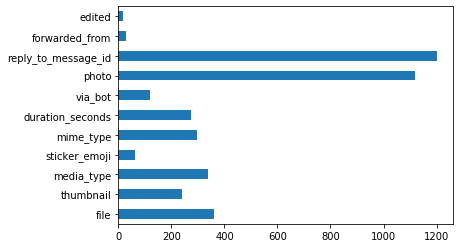

In [15]:
#dropping `text` messages and other columns that don't show interesting information
message_count_plot= message_count.drop(labels=['id','type','text','from','from_id','date','height','width'])
message_count_plot.plot.barh()

#### Some insights:
* We don't edit many of our messages after being sent
* We don't ussually forward messages
* We reply a lot of messages!
* We share a lot of images!
* We have a couple of bots
* The total amount of time in audio messages is relatively short
* We don't usually send a single emoji as a message
* We've shared over 300 files

##### Let's take a closer look at some of those insights...

In [16]:
reply_df= msg_df[['date','reply_to_message_id','from']].dropna()
reply_df

,date,reply_to_message_id,from
105,2019-05-05T16:17:09,11939.0,Alice
138,2019-05-20T17:03:29,12019.0,Alice
143,2019-05-24T20:49:20,12249.0,bot
148,2019-05-24T20:50:54,12254.0,bot
150,2019-05-24T23:09:11,12257.0,bot
...,...,...,...
22568,2020-07-10T19:28:00,38597.0,Bob
22601,2020-07-10T19:45:43,38660.0,Alice
22618,2020-07-10T19:48:21,38678.0,Alice
22682,2020-07-11T11:23:58,38732.0,Trudy


In [17]:
#some pandas-fu to create a df with the indexed dates for the replies
reply_df= pd.merge(reply_df.rename(columns={'reply_to_message_id': 'id'}),
        df[['reply_to_message_id','id','date']],
        on='id').rename(columns={'date_x': 'reply','date_y':'orig_msg'})[['reply','from','orig_msg']]
reply_df['delta']=pd.to_datetime(reply_df['reply']) - pd.to_datetime(reply_df['orig_msg']) #calculating the time delta
reply_df

,reply,from,orig_msg,delta
0,2019-05-05T16:17:09,Alice,2019-05-05T16:15:49,00:01:20
1,2019-05-20T17:03:29,Alice,2019-05-20T14:33:27,02:30:02
2,2019-05-24T20:49:20,bot,2019-05-24T20:49:20,00:00:00
3,2019-05-24T20:50:54,bot,2019-05-24T20:50:53,00:00:01
4,2019-05-24T23:09:11,bot,2019-05-24T23:09:10,00:00:01
...,...,...,...,...
1198,2020-07-10T19:28:00,Bob,2020-07-10T19:24:46,00:03:14
1199,2020-07-10T19:45:43,Alice,2020-07-10T19:45:33,00:00:10
1200,2020-07-10T19:48:21,Alice,2020-07-10T19:48:02,00:00:19
1201,2020-07-11T11:23:58,Trudy,2020-07-11T10:47:56,00:36:02


#### Now, let's plot each participant's delta time for replying.

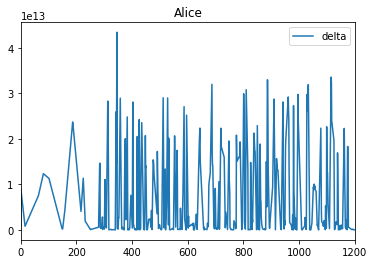

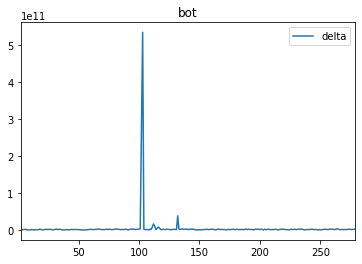

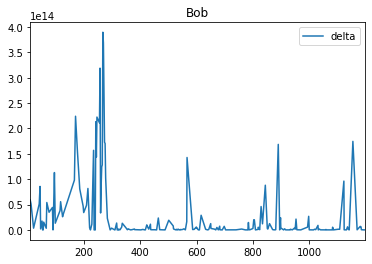

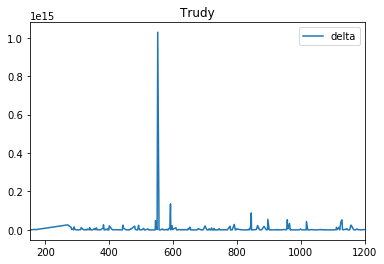

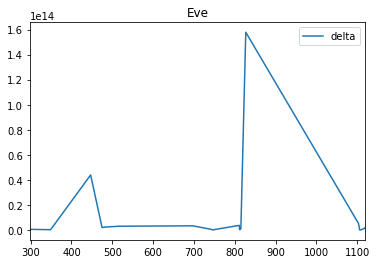

In [18]:
for friend in reply_df['from'].unique():
    reply_df.loc[reply_df['from']==friend].plot( y='delta',title=friend)

##### Apparently:
* `Alice` replies a lot, but takes several minutes to do so
* at some point the `bot` had an issue, but ussually replies instantly
* `Bob` has some seasonality, meaning every now and then he'll take his time
* `Trudy`doesn't take much time to reply, for the most part
* `Eve` doesn't reply much

### Let's move on to the next feature... Images!

##### Apparently, Telegram embeds the date on the file-name... kind of redundant if you ask me (?)

In [19]:
images_df= msg_df[['date','photo','from']].dropna()
images_df.sample(5)

,date,photo,from
11398,2020-05-06T11:25:58,photos/photo_600@06-05-2020_11-25-58.jpg,Bob
11718,2020-05-08T21:21:42,photos/photo_618@08-05-2020_21-21-42.jpg,Bob
20413,2020-07-01T09:02:20,photos/photo_1011@01-07-2020_09-02-20.jpg,Bob
16957,2020-06-10T18:57:16,photos/photo_840@10-06-2020_18-57-16.jpg,Bob
2124,2020-03-01T12:37:33,photos/photo_97@01-03-2020_12-37-33.jpg,Bob


#### Counting the images sent by group member and...Well, well, well! It would seem like Bob is a pretty visual guy... 

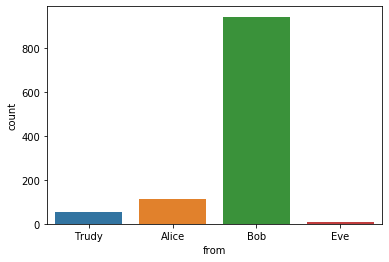

In [20]:
sns.countplot(x='from', data=images_df)

#### Let's see the actual distribution of images sent by Bob over time

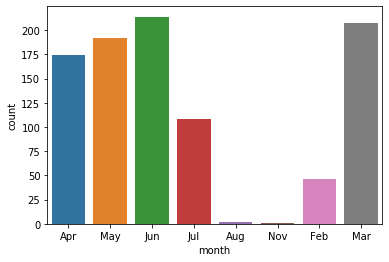

In [21]:
#images_df.sort_values(by="month", inplace=True)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
months = images_df["date"].apply(lambda date: month_names[int(date.split("-")[1])-1])

images_df['month']=months
bob_images_df= images_df.loc[images_df['from']=='Bob']

sns.countplot(x='month', data=bob_images_df)

##### looks like Bob alternates between months whith little to no activity and others when he sends over 175 pictures per month

### What about files? We've shared over 350 files over the past two years, that sounds like a lot

In [22]:
file_df= df[['date','file','from']].dropna()
file_df

,date,file,from
1,2018-02-24T10:44:15,stickers/sticker.webp,Alice
4,2018-02-24T10:44:57,stickers/sticker (1).webp,Alice
6,2018-02-24T10:46:19,video_files/animation.gif.mp4,Alice
8,2018-02-24T10:47:14,video_files/giphy.mp4,Alice
15,2018-02-24T10:49:02,video_files/giphy (1).mp4,Trudy
...,...,...,...
22288,2020-07-10T09:18:22,stickers/sticker (46).webp,Alice
22315,2020-07-10T12:29:20,video_files/mp4 (28).mp4,Bob
22316,2020-07-10T12:31:15,video_files/animation (26).gif.mp4,Alice
22671,2020-07-11T10:48:13,video_files/mp4 (29).mp4,Bob


#### Oh... now I get it! At a glance, most of the files are gif and animations... that makes sense, right?
##### Let's explore this a bit further

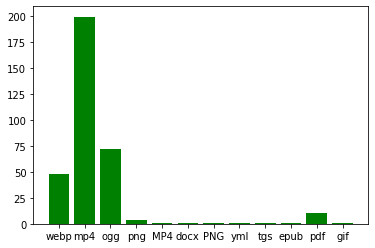

In [23]:
files_sent=file_df['file'].unique()
file_types=defaultdict(int)
for f in files_sent:
    file_types[f.split('.')[-1]]+=1

plt.bar(list(file_types.keys()),file_types.values(), color='g')
plt.show()

##### That was unexpected... there are a lot of audio files `.ogg` that I was not considering.

#### So... The majority of the files shared were animations and audio files, let's see who's been the most active sharing files

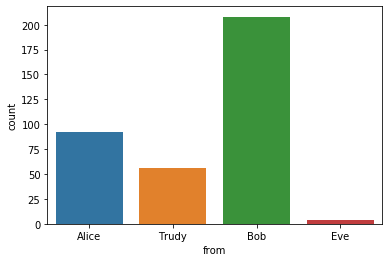

In [24]:
sns.countplot(x='from', data=file_df)

#### Once again, Bob proves he is the most visual member of the group when he sent twice as many gifs as Alice

In [25]:
#TODO:
# Explore the `text` based messages (22k messages should be the most juicy data)
# Show a word cloud for the most used words
# analyze individual's activity from text-based messages